In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import copy
from matplotlib.ticker import PercentFormatter
from IPython.display import clear_output
from sklearn.metrics.pairwise import linear_kernel, cosine_distances

pd.set_option('display.max_columns', None)
%config Completer.use_jedi = False
pd.options.display.float_format = '{:20,.2f}'.format

In [14]:
# Esta función pasa de string a datetime las columnas que se desea.

def cast_object_to_datetime(df, columns, the_format):
    
    for column in columns:
        
        df[column] = df[column].apply(lambda x: x if x is None else datetime.strptime(x[:-2], the_format))
        
    return df

In [83]:
location_juli_1 = r'C:\Users\jlizarraga\Documents\datathon-datasets\train.csv'
location_juli_2 = r'C:\Users\jlizarraga\Documents\datathon-datasets\metadata.csv'

location_fer_1 = r'C:\Users\fmrodriguez\Competencia\datathon-recomendacion\train.csv'
location_fer_2 = r'C:\Users\fmrodriguez\Competencia\datathon-recomendacion\metadata.csv'


# Cada uno tiene que cambiar la dirección de los datasets cuando corra la notebook.
df = pd.read_csv(location_juli_1)
metadata = pd.read_csv(location_juli_2, sep=';')
metadata_de_chequeo = pd.read_csv(location_juli_2, sep=';')

print(df.shape)
print(metadata.shape)

(3657801, 5)
(4366, 459)


In [3]:
# Observamos los primeros registros del dataset que contiene lo que vio cada account_id.
df.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0


In [6]:
# Observamos los primeros registros del dataset que contiene información sobre los shows que ofrece la empresa.
metadata.head(2)

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,description,reduced_desc,cast_first_name,credits_first_name,run_time_min,audience,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",Esteban recibe una noticia inesperada: va a se...,Esteban recibe una noticia inesperada: va a se...,"Rodrigo De la Serna, Paola Krum, Fernán Mirás,...",Daniel Barone,48.0,General,N,N,N,N,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",Víctor trabaja como carretillero. Un día recib...,"Trabajando como carretillero, Víctor recibe un...","Celso Franco, Víctor Sosa, Lali Gonzalez",Juan Carlos Maneglia,105.0,General,N,N,N,N,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z


In [13]:
print('Cantidad de usuarios distintos:', len(df.account_id.unique()))

Cantidad de usuarios distintos: 113881


In [8]:
print('Cantidad de contenidos distintos:', len(metadata.content_id.unique()))
print('(Recordar que los episodios de una serie, por ejemplo, tienen distintos asset_id, pero el mismo content_id.)')

Cantidad de contenidos distintos: 4367
(Recordar que los episodios de una serie, por ejemplo, tienen distintos asset_id, pero el mismo content_id.)


In [9]:
print('Cantidad de directores distintos:', len(metadata.credits_first_name.unique()))
print('Cantidad de audiencias distintas a las que puede estar dirigido un show:', len(metadata.audience.unique()))

Cantidad de directores distintos: 3260
Cantidad de audiencias distintas a las que puede estar dirigido un show: 11


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657801 entries, 0 to 3657800
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   account_id   int64  
 2   device_type  object 
 3   asset_id     float64
 4   tunein       object 
 5   tuneout      object 
 6   resume       int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 195.3+ MB


In [11]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asset_id            33144 non-null  int64  
 1   content_id          33123 non-null  float64
 2   title               33144 non-null  object 
 3   reduced_title       33144 non-null  object 
 4   episode_title       28997 non-null  object 
 5   show_type           33140 non-null  object 
 6   released_year       33144 non-null  float64
 7   country_of_origin   33140 non-null  object 
 8   category            33144 non-null  object 
 9   keywords            33142 non-null  object 
 10  description         33142 non-null  object 
 11  reduced_desc        33144 non-null  object 
 12  cast_first_name     24412 non-null  object 
 13  credits_first_name  20590 non-null  object 
 14  run_time_min        33144 non-null  float64
 15  audience            33143 non-null  object 
 16  made

In [17]:
# Transformamos a datetime las columnas 'tunein' y 'tuneout'
df = cast_object_to_datetime(df, ['tunein', 'tuneout'], '%Y-%m-%d %H:%M:%S')

# Creamos una columna que sea el tiempo que la persona estuvo mirando la serie/película.
# Es la diferencia entre cuando empezó y cuando terminó.
df['time_watching'] = df['tuneout'] - df['tunein']
df = df.drop(columns=['tunein', 'tuneout'])

# Pasamos esa columna nueva de tipo timedelta a float para que sea más fácil de usar.
# Luego obtenemos algunas métricas sobre el tiempo que pasa la gente viendo las series/películas.
df['time_watching'] = df['time_watching'].apply(lambda x: x.total_seconds() / 60)
df[['time_watching']].describe()

,time_watching
count,"3,657,801.00"
mean,26.97
std,29.39
min,2.00
25%,7.00
50%,17.00
75%,39.00
max,240.00


In [36]:
def plot_hist(data, title, xlabel, n_of_bins=10, figure_size=(12, 5), xticks=None):

    plt.figure(figsize=figure_size)
    plt.hist(data, weights=np.ones(len(data)) / len(data), bins=n_of_bins)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title(title)
    plt.xlabel(xlabel)
    
    if xticks is not None:
        plt.xticks(xticks)
    
    plt.show()

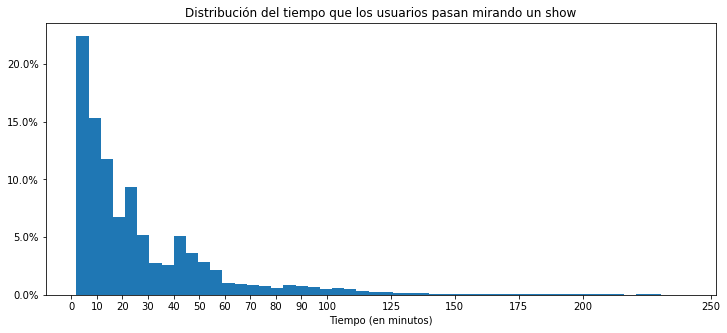

In [37]:
x_ticks = np.append(np.arange(0, 101, 10), [125, 150, 175, 200, 250])

plot_hist(df.time_watching, 'Distribución del tiempo que los usuarios pasan mirando un show', 
          'Tiempo (en minutos)', n_of_bins=50, xticks=x_ticks)

C:\Users\jlizarraga\Anaconda3\envs\practia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


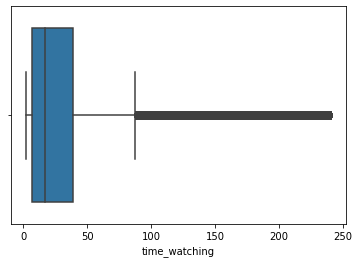

In [39]:
sns.boxplot(df.time_watching)
plt.show()

In [43]:
# Vemos cuáles son los tipos de dispositivo más usados.
# No sabemos si sirve para el modelo.

print('Tipos de dispositivos para ver shows y grado de utilización (en %)')
df.device_type.value_counts(normalize=True)*100

Tipos de dispositivos para ver shows y grado de utilización (en %)


STB                           81.84
STATIONARY                     6.14
PHONE                          5.92
CLOUD_CLIENT                   4.77
TABLET                         1.33
Name: device_type, dtype: float64

In [44]:
# Dropeamos la columna 'customer_id' porque no es relevante para el análisis. Solo nos sirve 'account_id'.

df = df.drop(columns=['customer_id'])

In [46]:
print('Tipos y cantidades (en %) de shows')
metadata.show_type.value_counts(normalize=True)*100

Tipos y cantidades (en %) de shows


TV                            47.35
Serie                         32.93
Película                      12.15
Web                            4.18
Gaming                         2.55
Rolling                        0.83
Series,Serie                   0.01
Name: show_type, dtype: float64

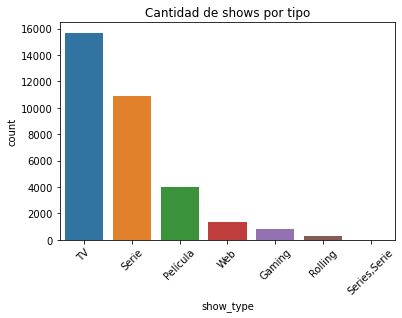

In [47]:
sns.countplot(x='show_type', data=metadata, order=metadata.show_type.value_counts().index)
plt.xticks(rotation=45)
plt.title('Cantidad de shows por tipo')
plt.show()

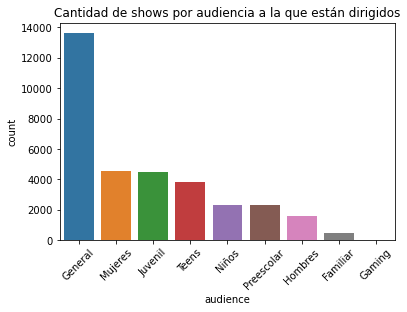

In [48]:
metadata['audience'] = metadata['audience'].str.title()

sns.countplot(x='audience', data=metadata, order=metadata.audience.value_counts().index)
plt.xticks(rotation=45)
plt.title('Cantidad de shows por audiencia a la que están dirigidos')
plt.show()

In [51]:
print('Datos sobre la duración de los shows:')
metadata.run_time_min.describe()

Datos sobre la duración de los shows:


count              33,123.00
mean                   48.09
std                    35.21
min                     0.00
25%                    22.00
50%                    43.00
75%                    67.00
max                   308.00
Name: run_time_min, dtype: float64

33123


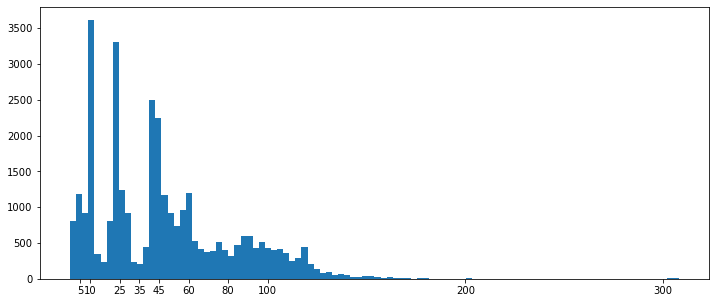

In [52]:
print(len(metadata.run_time_min))
plt.figure(figsize=(12, 5))
plt.hist(metadata['run_time_min'], bins=100)
plt.xticks([5, 10, 25, 35, 45, 60, 80, 100, 200, 300])
plt.show()

In [58]:
# Esta función crea las dummies para alguna columna.

# Si se pasa algún delimitador (delimiter), crea las dummies de una columna en la cual haya múltiples valores por fila.
# Por ejemplo, la columna 'category' tiene filas que dicen 'Suspenso/Terror'. 
# En ese caso se crean dos columnas ('Suspenso' y 'Terror') y se le pone un 1 a ese registro.
# Los parámetros que recibe son un DataFrame, una columna, un delimitador (en nuestro ejemplo: '/') y un prefijo para las nuevas columnas (opcional).

def create_dummies(df, column, delimiter=None, prefix=None):

    if delimiter is not None: # Si entra acá es porque hay múltiples valores en cada fila separados por algún delimitador.
    
        if prefix is None:
            prefix = column + '_'

        df = df.merge(df[column].str.get_dummies(sep=delimiter).add_prefix(prefix), left_index=True, right_index=True)
        
    else: # Si entra acá es porque cada fila tiene un solo valor. Es básicamente un pd.get_dummies convencional.
        
        dummy_columns = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummy_columns], axis=1)

    df.drop(columns=[column], inplace=True)
        
    return df

# Sistema de recomendación

In [65]:
# Eliminamos unos pocos registros que no tienen content_id porque no nos sirven para el sistema de recomendación.
metadata = metadata[~metadata.content_id.isnull()]

# Borramos columnas que no sirven, tienen muchos nulos o nos aumentarían demasiado la dimensionalidad si quisiéramos incluirlas.
to_delete = ['title', 'reduced_title', 'episode_title', 'description', 'reduced_desc', 'create_date', 'modify_date', 'start_vod_date', 'end_vod_date',
             'cast_first_name', 'credits_first_name', 'close_caption', 'sex_rating', 'violence_rating', 'language_rating', 'dialog_rating', 'fv_rating']
metadata = metadata.drop(columns=to_delete)

# Eliminamos los content_id duplicados porque hacen referencia a cosas que para nosotros son lo mismo.
# Por ejemplo, los episodios de una serie tienen distinto asset_id, pero el mismo content_id. Con quedarnos con un solo episodio ya nos basta.
metadata = metadata[~metadata.content_id.duplicated()]

In [67]:
# Las siguientes columnas tienen 'N' e 'Y' representando 'No' y 'Yes'.
# Cambiamos las N por 0 y las Y por 1.
cols_to_change = ['made_for_tv', 'pay_per_view', 'pack_premium_1', 'pack_premium_2']
metadata.loc[:, cols_to_change] = metadata[cols_to_change].replace({'N':0, 'Y':1})

# Arreglamos algunas categorías mal escritas
dict_to_replace_category = {'Accion':'Acción', 'Aventuras':'Aventura', 'Dibujos animados':'Dibujos Animados', 'Ciencia ficción':'Ciencia Ficción',
                           'Familia':'Familiar', 'Infantil, Comedia':'Infantil/Comedia'}
metadata.category.replace(dict_to_replace_category, inplace=True, regex=True)

# Arreglamos un show_type mal escrito.
metadata.show_type.replace({'Series,Serie':'Serie'}, inplace=True)

# Hacemos que todos los valores 'audience' empiecen cada palabra con mayúscula y sigan con minúscula.
metadata['audience'] = metadata['audience'].str.title()

In [68]:
metadata = create_dummies(metadata, 'category', '/')
metadata = create_dummies(metadata, 'keywords', ',')
metadata = create_dummies(metadata, 'show_type')
metadata = create_dummies(metadata, 'country_of_origin')
metadata = create_dummies(metadata, 'audience')

In [69]:
# Creamos una columna nueva 'years_since_premiere' que nos dice qué tan antiguo es el show.
metadata.released_year = datetime.now().year - metadata.released_year
metadata.rename(columns={'released_year':'years_since_premiere'}, inplace=True)

In [71]:
# Reseteamos el índice del DataFrame.
metadata.reset_index(drop=True, inplace=True)

In [72]:
print(metadata.shape)
metadata.sample(3)

(4366, 459)


,asset_id,content_id,years_since_premiere,run_time_min,made_for_tv,pay_per_view,pack_premium_1,pack_premium_2,category_Acción,category_Animación,category_Animales,category_Aventura,category_Biografía,category_Bélico,category_Ciencia,category_Ciencia Ficción,category_Cocina,category_Comedia,category_Competencia,category_Crimen,category_Cultura,category_Deporte,category_Dibujos Animados,category_Documental,category_Drama,category_Entretenimiento,category_Entrevistas,category_Espectáculo,category_Familiar,category_Familiarr,category_Fantasía,category_Historia,category_Humor,category_Infantil,category_Interés General,category_Investigación,category_Magazine,category_Moda,category_Musical,category_Música,category_Naturaleza,category_Periodístico,category_Policial,category_Político,category_Reality,category_Religión,category_Restauración,category_Romance,category_Suspenso,category_Teatro,category_Terror,category_Viajes,category_Western,keywords_ Bizarras,keywords_ Medieval,keywords_20s,keywords_30s,keywords_40s,keywords_50s,keywords_60s,keywords_70s,keywords_80s,keywords_90s,keywords_Abogados,keywords_Abusos,keywords_Accidentes,keywords_Aclamadas,keywords_Actualidad,keywords_Adicciones,keywords_Adolescentes,keywords_Adrenalina,keywords_Aeropuerto,keywords_Agentes,keywords_Aislados,keywords_Aliens,keywords_Amigos,keywords_Amistad,keywords_Amor,keywords_Androides,keywords_Animación,keywords_Animales,keywords_Animé,keywords_Antihéroes,keywords_Antiprincesas,keywords_Antisistema,keywords_Apocalipsis,keywords_Apocalípsis,keywords_Armas,keywords_Arte,keywords_Artes Marciales,keywords_Artistas,keywords_Asesinos,keywords_Asia,keywords_Asiáticos,keywords_Astronautas,keywords_Autos,keywords_Aventuras,keywords_Aves,keywords_Aviones,keywords_Avión,keywords_BYN,keywords_Backstage,keywords_Bailarines,keywords_Baile,keywords_Barcos,keywords_Belleza,keywords_Biblia,keywords_Biografía,keywords_Bizarra,keywords_Bizarras,keywords_Bosque,keywords_Boxeo,keywords_Brujas,keywords_Burdel,keywords_Caballos,keywords_Canciones,keywords_Canibalismo,keywords_Casamiento,keywords_Casino,keywords_Catástrofes,keywords_Celebridades,keywords_Ciencia,keywords_Cine,keywords_Circo,keywords_Ciudad,keywords_Clásicas,keywords_Cocineros,keywords_Comedia,keywords_Comics,keywords_Comidas,keywords_Competencia,keywords_Congelados,keywords_Conspirativas,keywords_Corporación,keywords_Corrupción,keywords_Crecer,keywords_Criaturas,keywords_Crimen,keywords_Criminales,keywords_Culto,keywords_Cultura,keywords_Cómic,keywords_DC Comics,keywords_De Color,keywords_De Libros,keywords_De libros,keywords_Decoración,keywords_Deportistas,keywords_Depredadores,keywords_Desamor,keywords_Despecho,keywords_Detectives,keywords_Dictadores,keywords_Dimensiones,keywords_Dinero,keywords_Dinosaurios,keywords_Director,keywords_Directores,keywords_Diseño,keywords_Disney,keywords_Distopía,keywords_Divorcio,keywords_Dragones,keywords_Dreamworks,keywords_Droga,keywords_Educativo,keywords_Embarazos,keywords_Emmy,keywords_Empresarios,keywords_Encierro,keywords_Enfermedades,keywords_Entretenimiento,keywords_Entrevistas,keywords_Erótica,keywords_Escritores,keywords_Escuela,keywords_Espacio,keywords_Espectaculos,keywords_Espectáculos,keywords_Espionaje,keywords_Espíritus,keywords_Estafas,keywords_Europa,keywords_Exorcismo,keywords_Experimentos,keywords_Exploración,keywords_Familia,keywords_Fantasía,keywords_Feminismo,keywords_Fiestas,keywords_Flow,keywords_Futurismo,keywords_Fútbol,keywords_Fútbol Americano,keywords_Galaxia,keywords_Gaming,keywords_Genios,keywords_Gobierno,keywords_Golden Globe,keywords_Granja,keywords_Guerra,keywords_Guerra Mudial,keywords_Guerra Mundial,keywords_Guerreros,keywords_Hackers,keywords_Halloween,keywords_Hechiceros,keywords_Hechos Reales,keywords_Hechos reales,keywords_Hermanos,keywords_Historia,keywords_Historias Cruzadas,keywords_Hockey,keywords_Hombres,keywords_Horror,keywords_Hospital,keywords_Hotel,keywords_Humor Negro,keywords_Héroes,keywords_Iconos00,keywords_Iconos70,keyword

In [84]:
def create_similarity_matrix(df):
    
    cosine_similarities = 1 - cosine_distances(df, df)
    
    sparsity=float(len(cosine_similarities.nonzero()[0]))
    sparsity/=(cosine_similarities.shape[0]*cosine_similarities.shape[1])
    sparsity*=100
    print('Coeficiente de sparseidad: {:4.2f}%'.format(sparsity))
    print('Dimensiones de la matriz: {}'.format(cosine_similarities.shape))
    
    return cosine_similarities

In [80]:
similarity_matrix = create_similarity_matrix(metadata.drop(columns=['asset_id', 'content_id', 'run_time_min']))

Coeficiente de sparseidad: 99.59%
Dimensiones de la matriz: (4366, 4366)


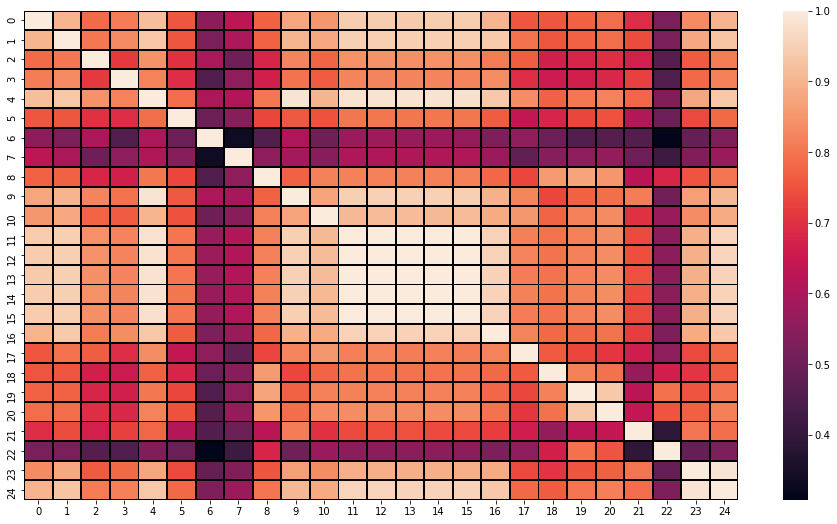

In [297]:
n = 25
plt.figure(figsize=(16,9))
sns.heatmap(pd.DataFrame(similarity_matrix).iloc[0:n, 0:n], linewidths=0.9, linecolor='black', xticklabels='auto')
plt.show()

In [254]:
def recomendar_shows(df_usuarios, nro_usuario, metadata, metadata_de_chequeo, similarity_matrix):
    
    # Filtramos el dataset de usuarios para quedarnos solo con el que se pide por parámetro.
    user = df_usuarios[df_usuarios.account_id==nro_usuario]
    
    # Si el usuario vio varias veces el mismo show, nos quedamos solo con el primero de esos registros.
    user = user[~user.asset_id.duplicated()]

    # Unimos los datos del usuario con los de los shows para tener lo que nos interesa: el content_id de cada show que vio.
    user = user.merge(metadata_de_chequeo, on='asset_id')
    user = user[['account_id', 'content_id']]
    
    # Obtenemos los índices que corresponden a los content_id que vio el usuario.
    indices = metadata[metadata.content_id.isin(list(user.content_id))].index
    
    # Usamos esos índices para filtrar la matriz de similaridad y quedarnos solo con las filas que corresponden a los contenidos que vio el usuario.
    vistas_usuario = similarity_matrix.loc[indices, :]

    # Sumamos los puntajes de similitud que tuvo cada show del dataset con respecto a los shows que vio el usuario.
    resultados = vistas_usuario.sum(axis=0)

    # De todos los resultados quitamos los que corresponden a shows que el usuario ya había visto.
    # Si no hiciéramos esto, se le recomendarían shows que ya habría visto.
    resultados_filtrados = resultados[~resultados.index.isin(list(vistas_usuario.index))]

    # Nos quedamos con los 20 mejores puntajes.
    resultados_final = resultados_filtrados.sort_values(ascending=False)[0:20]
    
    # Obtenemos los content_id recomendados para el usuario.
    content_id_recomendados = list(metadata.loc[resultados_final.index, 'content_id'])
    
    # En el dataset de metadata original (sin modificaciones), buscamos los shows que tienen esos content_id.
    recomendaciones = metadata_de_chequeo[metadata_de_chequeo.content_id.isin(content_id_recomendados)]
    
    # Como nos basta con recomendar un content_id (no necesitamos recomendar cada uno de sus asset_id asociados), hacemos un último filtro.
    recomendaciones = recomendaciones[~recomendaciones.content_id.duplicated()]
    recomendaciones = recomendaciones.set_index(resultados_final.index)
    
    entregable = pd.DataFrame({'account_id':nro_usuario, 'content_ids':[list(recomendaciones.content_id.astype(int))]})
    
    return recomendaciones, entregable

In [255]:
recomendaciones, entregable = recomendar_shows(df, 102343, metadata, metadata_de_chequeo, pd.DataFrame(similarity_matrix))
recomendaciones

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,description,reduced_desc,cast_first_name,credits_first_name,run_time_min,audience,made_for_tv,close_caption,sex_rating,violence_rating,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
608,24787,45.00,T:3 Ep:74 Doctora Juguetes,Doctora_Jug_T3_E74,La Doctora Juguetes viaja a Washington / Aire ...,TV,"2,015.00",US,Infantil/Dibujos Animados,Educativo,Doc y sus juguetes reciben una invitación a la...,La Doctora Juguetes es una niña de seis años q...,NaN,Norton Virgien,23.00,Preescolar,N,N,N,N,N,N,N,N,N,N,2020-09-19T00:32:09.0Z,2020-10-08T07:23:48.0Z,2020-09-14T00:00:00.0Z,2020-12-01T23:59:59.0Z
55,33092,50.00,T:1 Ep:10 Las Aventuras De Brandy y El Sr.Bigotes,Brand_Bigote_T1_E10,Bananas Republic,TV,"2,004.00",US,Infantil/Dibujos Animados,"Animales,Selva","Brandy, disgustado con la dictadura de Gaspar,...",Sigue las desventuras de dos compañeros poco c...,NaN,Russell Marcus,23.00,Teens,N,N,N,N,N,N,N,N,N,N,2020-10-22T21:12:23.0Z,2020-10-23T00:06:05.0Z,2020-10-17T00:00:00.0Z,2020-12-01T23:59:00.0Z
375,27976,55.00,T:4 Ep:120 La casa de Mickey Mouse,La_Casa_D_M_T4_E120,El rock de la casa de Mickey,TV,"2,006.00",US,Infantil/Dibujos Animados,Educativo,"Mickey, Minnie, el Pato Donald, Daisy, Goofy y...","Mickey, Minnie, el Pato Donald, Daisy, Goofy y...",NaN,NaN,24.00,Preescolar,N,N,N,N,N,N,N,N,N,N,2020-10-22T23:50:17.0Z,2020-10-23T05:06:04.0Z,2020-10-17T00:00:00.0Z,2020-12-01T23:59:00.0Z
592,1684,93.00,John Legend - Live At Roundhouse,John_Legend___Live_,NaN,Película,"2,013.00",GB,Entretenimiento/Música,"Música,Recital,Artistas",John Legend traerá un poco de ritmo a The Roun...,John Legend traerá un poco de ritmo a The Roun...,NaN,Jim Gable,97.00,Juvenil,N,N,N,N,N,N,N,N,N,N,2020-05-15T20:43:23.0Z,2020-05-15T21:06:03.0Z,2019-12-03T00:00:00.0Z,2020-12-03T23:59:00.0Z
4287,13090,364.00,Lady Gaga - Itunes Festival,Lady_Gaga_Itunes_Fe,NaN,Película,"2,013.00",GB,Entretenimiento/Música,"Recital,Música,Artistas,Mujeres",La actuación de Lady Gaga en el iTunes Festiva...,La actuación de Lady Gaga en el iTunes Festiva...,Lady Gaga,NaN,71.00,Juvenil,N,N,N,N,N,N,N,N,N,N,2019-10-09T11:14:21.0Z,2020-11-24T02:34:33.0Z,2019-10-09T00:00:00.0Z,2020-12-14T23:59:59.0Z
594,5695,375.00,Amy Winehouse - Live In London,Amy_Winehouse__Live,NaN,Película,"2,007.00",GB,Entretenimiento/Música,"Música,Recital,Artistas,Mujeres",El recital en Londres de la cantante y composi...,El recital en Londres de la cantante y composi...,Amy Winehouse,Hamish Hamilton,66.00,Juvenil,N,N,N,N,N,N,N,N,N,N,2019-11-21T19:28:07.0Z,2020-11-19T08:41:01.0Z,2019-11-19T00:00:00.0Z,2020-12-14T23:59:59.0Z
1581,15522,377.00,Justin Timberlake - Itunes Festival,Justin_Timberlake__,NaN,Película,"2,013.00",GB,Entretenimiento/Música,"Música,Recital,Artistas",Justin Timberlake cerró la penúltima noche del...,Justin Timberlake cerró la penúltima noche del...,Justin Timberlake,NaN,134.00,Juvenil,N,N,N,N,N,N,N,N,N,N,2019-11-22T08:13:45.0Z,2020-11-19T08:44:07.0Z,2019-11-19T00:00:00.0Z,2020-12-14T23:59:59.0Z
4252,6053,592.00,R.E.M. Live in Milan,R_E_M__Live_in_Mila,NaN,Película,"2,008.00",GB,Entretenimiento/Música,"Música,Recital,Artistas,Rock","Show celebrado en Milán, Italia en 2008. Con g...","Show celebrado en Milán, Italia en 2008. Con g...","Michael Stipe, Peter Buck, Mike Mills",Joe Thomas,53.00,General,N,N,N,N,N,N,N,N,N,N,2020-11-28T22:34:22.0Z,2020-12-07T23:44:09.0Z,2020-11-25T00:00:00.0Z,2020-12-14T23:59:59.0Z
45,2735,594.00,Elton John - Live in Vegas,Elton_John___Live_i,NaN,Película,"2,004.00",US,Entretenimiento/Música,"Música,Recital,Artistas,Rock",El 'Piano rojo' es un espectáculo multimedia d...,El 'Piano rojo' es un espectáculo que reúne la...,Elton John,Clive Banks,99.00,General,N,N,N,N,N,N,N,N,N,N,2020-11-29T06:14:34.0Z,2020-12-07T23:28:05.0Z,2020-11-27T00:00:00.0Z,2020-12-14T23:59:59.0Z
595,8063,

In [271]:
def crear_entregable(df_usuarios, metadata, metadata_de_chequeo, similarity_matrix):
    
    similarity_matrix = pd.DataFrame(similarity_matrix)
    users_list = np.sort(df_usuarios.account_id.unique())
    df_entregable = pd.DataFrame({'account_id':None, 'content_ids':None}, index=[0])
    
    for user in users_list:
        
        clear_output(wait=True)
        print('Procesando usuario {} de {}.'.format(user, len(users_list)))
        _, entregable = recomendar_shows(df_usuarios, user, metadata, metadata_de_chequeo, similarity_matrix)
        df_entregable = pd.concat([df_entregable, entregable], ignore_index=True)
        
    return df_entregable

In [269]:
df_entregable = crear_entregable(df, metadata, metadata_de_chequeo, similarity_matrix)

Procesando usuario 113880


In [272]:
df_entregable_2 = df_entregable.drop(columns=['recomendaciones'])

In [276]:
df_entregable_3 = df_entregable_2.reset_index(drop=True)

In [279]:
df_entregable_3.drop([0], inplace=True)
df_entregable_3.reset_index(drop=True, inplace=True)

In [294]:
df_entregable_3.to_csv('df_entregable_3.csv', header=False, index=False)